In [31]:
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc

In [32]:
testfile = 'Bladder Project pCR Prediction Data (Updated 030222).txt'
df=pd.read_csv(testfile,sep='\t', index_col=0)
display(df)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Incidental PC,utDNA,TF99
ID,,,,,,,,,,,
WBC1045,0,63,1,1,1,1,1,1,1,2.4,2.400
WBC1050,1,63,2,1,1,1,1,1,0,0.0,2.500
WBC1058,0,78,1,1,1,0,0,1,0,5.9,2.400
WBC1062,0,77,1,1,0,1,1,1,0,2.4,1.600
WBC1063,1,67,1,1,1,0,1,1,0,0.0,1.700
...,...,...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,0,0.0,0.000
WBC1313,0,48,1,1,0,0,1,1,0,1.9,18.300
WBC1314,1,73,2,1,1,1,1,1,0,0.3,0.000


In [33]:
# Perform operation on utDNA and TF99 and drop the unwanted columns
testratio=32/74
df_test = df.copy()
df_test['Operation'] = np.power((np.array(df['utDNA']) + 1) * (np.array(df['TF99']) + 1), 1.5)
df_test = df_test[['pCR', 'Age', 'Sex', 'Race', 'Urothelial', 'Smoking', 'NAC', 'MIBC', 'Operation']]
display(df_test)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Operation
ID,,,,,,,,,
WBC1045,0,63,1,1,1,1,1,1,39.304000
WBC1050,1,63,2,1,1,1,1,1,6.547900
WBC1058,0,78,1,1,1,0,0,1,113.629740
WBC1062,0,77,1,1,0,1,1,1,26.283210
WBC1063,1,67,1,1,1,0,1,1,4.436553
...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,1.000000
WBC1313,0,48,1,1,0,0,1,1,418.728923
WBC1314,1,73,2,1,1,1,1,1,1.482228


In [34]:
# Perform machine learning
X=df_test.drop(['pCR'],axis=1)
Y=df_test["pCR"].copy()
ind = df_test.index
trainX,testX,trainY,testY,train_in,test_in =  train_test_split(X,Y,ind,test_size=testratio, random_state=0)
my_final_classifier = RandomForestClassifier(n_estimators=2000, oob_score=True, random_state=1)
my_final_classifier.fit(trainX, trainY)

# Get the probability predictions 
pred = my_final_classifier.predict_proba(testX)[:,1]
pred_train = my_final_classifier.predict_proba(trainX)[:,1]
pred_all = my_final_classifier.predict_proba(trainX.append(testX))[:,1]

print('Oob_score =', my_final_classifier.oob_score_)
print('ROC Score =', roc_auc_score(testY, my_final_classifier.predict_proba(testX)[:,1]))

# Get the sensitivity and specificity for each set of data

# Training
fpr_train, tpr_train, thresholds_train = roc_curve(trainY, pred_train)
auc_train = metrics.roc_auc_score(trainY, pred_train)
sens_train_arr = tpr_train
spec_train_arr = 1 - fpr_train
gmeans_train = np.sqrt(sens_train_arr * spec_train_arr)
ix_train = np.argmax(gmeans_train)


# Test
fpr, tpr, thresholds = roc_curve(testY, pred)
auc_test = metrics.roc_auc_score(testY, pred)

# All
fpr_all, tpr_all, thresholds_all = roc_curve(trainY.append(testY), pred_all)
auc_all = metrics.roc_auc_score(trainY.append(testY), pred_all)

# Find the best threshold
thresh = thresholds_train[ix_train]

# Calculate specificity and sensitivities using confusion matrix
y_pred_test = list((pred >= thresh).astype(int))
cm1 = confusion_matrix(list(testY), y_pred_test)
spec_pred = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sens_pred = cm1[1,1]/(cm1[1,0]+cm1[1,1])

y_pred_train = list((pred_train >= thresh).astype(int))
cm1 = confusion_matrix(list(trainY), y_pred_train)
spec_train = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sens_train = cm1[1,1]/(cm1[1,0]+cm1[1,1])

y_pred_all = list((pred_all >= thresh).astype(int))
cm1 = confusion_matrix(list(trainY.append(testY)), y_pred_all)
spec_all = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sens_all = cm1[1,1]/(cm1[1,0]+cm1[1,1])

print('Best Threshold=%f, G-Mean=%.3f' % (thresh, gmeans_train[ix_train]), '\n')

df_prob_train = pd.DataFrame([list(trainY), list(pred_train), y_pred_train], index=['pCR_Train', 'Probability', 'Prediction']).T
df_prob_test = pd.DataFrame([list(testY), list(pred), y_pred_test], index=['pCR_Test', 'Probability', 'Prediction']).T
df_prob = pd.DataFrame([list(trainY.append(testY)), list(pred_all), y_pred_all], index=['pCR_All', 'Probability', 'Prediction']).T
display(df_prob_train)
display(df_prob_test)
display(df_prob)
df_prob_train.to_csv(testfile + '_prob_train.txt', sep='\t')
df_prob_test.to_csv(testfile + '_prob_test.txt', sep='\t')
df_prob.to_csv(testfile + '_prob_combined.txt', sep='\t')

# Display sensitivities and specificities
df_ss = pd.DataFrame([[sens_pred, spec_pred], \
          [sens_train, spec_train], \
          [sens_all, spec_all]],\
         columns=['Sensitivity', 'Specificity'], index=['Test', 'Train', 'All'])
display(df_ss)

Oob_score = 0.6666666666666666
ROC Score = 0.8690476190476191
Best Threshold=0.664500, G-Mean=1.000 



,pCR_Train,Probability,Prediction
0,1.0,0.7225,1.0
1,0.0,0.1975,0.0
2,0.0,0.0710,0.0
3,1.0,0.8650,1.0
4,1.0,0.7650,1.0
5,0.0,0.2200,0.0
6,0.0,0.0165,0.0
7,0.0,0.0550,0.0
8,0.0,0.0310,0.0
9,1.0,0.8850,1.0


,pCR_Test,Probability,Prediction
0,1.0,0.7970,1.0
1,1.0,0.1425,0.0
2,0.0,0.6055,0.0
3,0.0,0.3825,0.0
4,1.0,0.5305,0.0
5,0.0,0.4805,0.0
6,0.0,0.2680,0.0
7,0.0,0.2275,0.0
8,1.0,0.8030,1.0
9,0.0,0.2110,0.0


,pCR_All,Probability,Prediction
0,1.0,0.7225,1.0
1,0.0,0.1975,0.0
2,0.0,0.0710,0.0
3,1.0,0.8650,1.0
4,1.0,0.7650,1.0
...,...,...,...
69,1.0,0.4560,0.0
70,0.0,0.1010,0.0
71,0.0,0.5420,0.0
72,1.0,0.7350,1.0


,Sensitivity,Specificity
Test,0.555556,1.0
Train,1.000000,1.0
All,0.771429,1.0


In [22]:
# Using the best cutpoint, predict the pCR values and calculate mean absolute error
y_pred = list((pred_all >= thresh).astype(int))
indices = train_in.append(test_in)
df_res = pd.DataFrame(y_pred, index=indices, columns=['Prediction'])
df = pd.concat([df, df_res], axis=1)
display(df)
y_true = np.array(df['pCR'])
y_pred = np.array(df['Prediction'])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred), '\n')

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Incidental PC,utDNA,TF99,Prediction
WBC1045,0,63,1,1,1,1,1,1,1,2.4,2.400,0
WBC1050,1,63,2,1,1,1,1,1,0,0.0,2.500,1
WBC1058,0,78,1,1,1,0,0,1,0,5.9,2.400,0
WBC1062,0,77,1,1,0,1,1,1,0,2.4,1.600,0
WBC1063,1,67,1,1,1,0,1,1,0,0.0,1.700,0
...,...,...,...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,0,0.0,0.000,1
WBC1313,0,48,1,1,0,0,1,1,0,1.9,18.300,0
WBC1314,1,73,2,1,1,1,1,1,0,0.3,0.000,1
WBC1315,0,76,1,2,1,0,1,1,1,31.3,21.060,0


Mean Absolute Error: 0.10810810810810811 



In [23]:
# Use the confusion matrix to check for the sensitivity and specificity values for all data
cm1 = confusion_matrix(df['pCR'], df['Prediction'])
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity)
print('Specificity : ', specificity)

Sensitivity :  0.7714285714285715
Specificity :  1.0


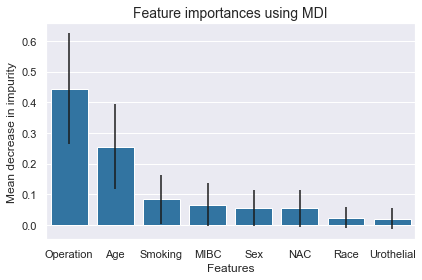

In [24]:
import seaborn as sns
# Plot the importance of features
feature_names = np.array(X.columns)
std = np.std([tree.feature_importances_ for tree in my_final_classifier.estimators_], axis=0)
importances = my_final_classifier.feature_importances_

forest_importances = pd.DataFrame([feature_names, importances, std], index=['Features', 'Importances', 'STD'])
forest_importances = forest_importances.T
forest_importances.sort_values(by=['Importances'], inplace=True, ascending=False)
fig, ax = plt.subplots()
bar = sns.barplot(x='Features', y='Importances', yerr=forest_importances['STD'], ax=ax, data=forest_importances, color='tab:blue')
ax.set_title("Feature importances using MDI", fontsize=14)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig(testfile + '_feature_importance.pdf', bbox_inches='tight')

In [25]:
df_train = df.loc[train_in, :]
df_test = df.loc[test_in, :]

In [26]:
# Save file with prediction
df.to_csv(testfile + '_prediction_all.txt', sep='\t')
df_train.to_csv(testfile + '_prediction_train.txt', sep='\t')
df_test.to_csv(testfile + '_prediction_test.txt', sep='\t')

,FPR Train,TPR Train
0,0.00,0.000000
1,0.00,0.058824
2,0.00,1.000000
3,0.40,1.000000
4,0.48,1.000000
5,0.52,1.000000
6,0.60,1.000000
7,0.88,1.000000
8,0.96,1.000000
9,1.00,1.000000


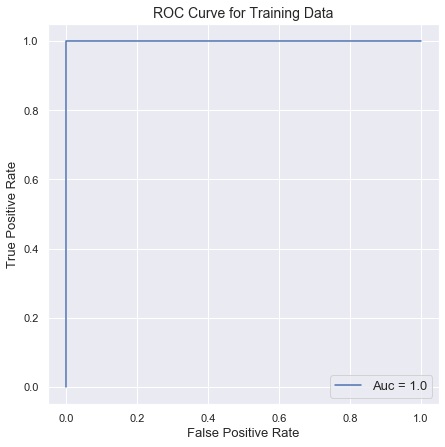

In [27]:
# Training ROC Curve
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(fpr_train, tpr_train, label='Auc = ' + str(np.around(auc_train, decimals=2)))
df_ROC_train = pd.DataFrame([fpr_train, tpr_train], index=['FPR Train', 'TPR Train']).T
display(df_ROC_train)
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curve for Training Data', fontsize=14)
plt.legend(fontsize=13)
plt.savefig(testfile + '_roc_train.pdf', bbox_inches='tight')
df_ROC_train.to_csv(testfile + '_ROC_train.txt', sep='\t')

,FPR Train,TPR Train
0,0.000000,0.000000
1,0.000000,0.055556
2,0.000000,0.555556
3,0.071429,0.555556
4,0.071429,0.666667
5,0.142857,0.666667
6,0.142857,0.777778
7,0.214286,0.777778
8,0.214286,0.833333
9,0.285714,0.833333


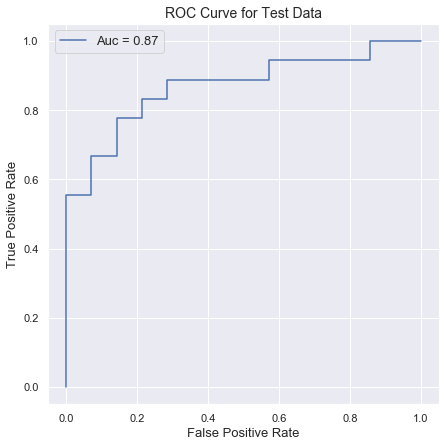

In [28]:
# Testing ROC Curve
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(fpr, tpr, label='Auc = ' + str(np.around(auc_test, decimals=2)))
df_ROC_test = pd.DataFrame([fpr, tpr], index=['FPR Train', 'TPR Train']).T
display(df_ROC_test)
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curve for Test Data', fontsize=14)
plt.legend(fontsize=13)
plt.savefig(testfile + '_roc_test.pdf', bbox_inches='tight')
df_ROC_test.to_csv(testfile + '_ROC_test.txt', sep='\t')

,FPR Train,TPR Train
0,0.000000,0.000000
1,0.000000,0.028571
2,0.000000,0.771429
3,0.025641,0.771429
4,0.025641,0.828571
5,0.051282,0.828571
6,0.051282,0.885714
7,0.076923,0.885714
8,0.076923,0.914286
9,0.102564,0.914286


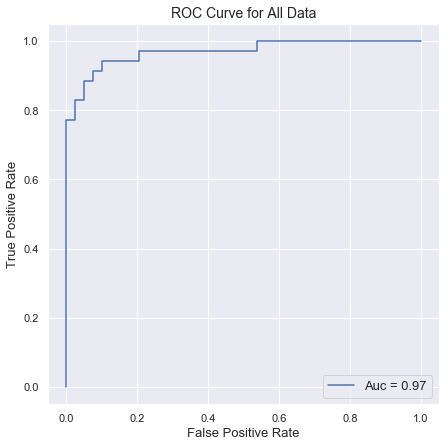

In [29]:
# Combined ROC Curve
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(fpr_all, tpr_all, label='Auc = ' + str(np.around(auc_all, decimals=2)))
df_ROC = pd.DataFrame([fpr_all, tpr_all], index=['FPR Train', 'TPR Train']).T
display(df_ROC)
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curve for All Data', fontsize=14)
plt.legend(fontsize=13)
plt.savefig(testfile + '_roc_all.pdf', bbox_inches='tight')
df_ROC.to_csv(testfile + '_ROC_combined.txt', sep='\t')

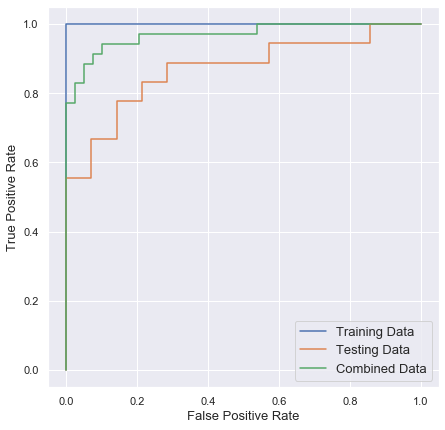

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(fpr_train, tpr_train, label='Training Data')
ax.plot(fpr, tpr, label='Testing Data')
ax.plot(fpr_all, tpr_all, label='Combined Data')
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
plt.legend(fontsize=13)
plt.savefig(testfile + '_roc_combined.pdf', bbox_inches='tight')